# FBI Crime Data Analysis

### Yu-Heng Lei (yuhengl1), Bo-Cheng Lin (bochengl), Xiaoyu Qiu (xiaoyuq)

## Motivation
Emerging crime incidents have raised awareness of personnel security. Therefore, it is becoming more important to understand crime data to identify key factors and their relationship with incidents behind the scene. Security agencies may leverage such analysis to gain insights and even influence their decision making.

## Libraries Used

For manipulating CSV files, we will use packages like `pandas` and `NumPy` to preprocess and reorganize them into DataFrames.

For data visualization, we will use `seaborn`, `Matplotlib`, `GeoPandas`, and `Shapely` for exploratory analysis to find interesting insight hidden in the data.

In [1]:
# Pre-processing
import collections
import numpy as np
import pandas as pd
import math

# General visualization 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Geospatial visualization
import geopandas as gpd
import shapely
from shapely.geometry import Point
from geopy.geocoders import GoogleV3
from scipy import ndimage

In [2]:
# Display otpions
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 100)
np.set_printoptions(linewidth=100)

## Project Outline

**TODO: Update with the correct sections and internal links**

This project will cover the following major sections:
- [Data Pre-processing](#Data-Pre-processing)
- Exploratory Data Analysis
  - [Overall Statistics](#Overall-Statistics)
  - [Geospatial Analysis](#Geospatial-Analysis)
  - [Relationship Between "Relationship" and "Offense"](#Relationship-between-"relationship"-and-"offense")
  - [Coordinate reference systems](#Coordinate-reference-systems)
  - [Example application: adddress2neighborhood](#Example-application:-address2neighborhood)
  - [Example applicaiton: Yelp by neighborhood](#Example-application:-Yelp-by-neighborhood)

## Data Pre-processing

Our main dataset is the National Incident-Based Reporting System (NIBRS) dataset from FBI crime data explorer downloaded here:

- https://crime-data-explorer.fr.cloud.gov/downloads-and-docs

For a specific state-year combination, e.g., `PA-2016`, there are 43 CSV files that needs to be transformed into useful format. The `README` in the downloaded zip file provides explanation of some tables and variables.

According to the documentation, we need to establish the relationships between tables, such as mapping `offense_type_id` into the *human-readable* string `offense_name`.

First, define the 43 table names as lists or dictionaries. We will reuse them in *loops* later. The lookup tables are defined as a dictionary of `{tableName: (oldCol, newCol)}` format.

In [3]:
# 10 primary (more important) tables
primaryTables = [
    'nibrs_arrestee', 'nibrs_bias_motivation', 'nibrs_incident', 'nibrs_offender', 'nibrs_offense',
    'nibrs_property_desc', 'nibrs_property', 'nibrs_victim_injury', 'nibrs_victim_offender_rel', 'nibrs_victim'
]

# 24 lookup tables as a dictionary of {table_name: (oldCol, newCol)} format
lookupTables = {
    'nibrs_activity_type': ('activity_type_id', 'activity_type_name'),
    'nibrs_age': ('age_id', 'age_name'),
    'nibrs_arrest_type': ('arrest_type_id', 'arrest_type_name'), 
    'nibrs_assignment_type': ('assignment_type_id', 'assignment_type_name'),
    'nibrs_bias_list': ('bias_id', 'bias_name'),
    'nibrs_circumstances': ('circumstances_id', 'circumstances_name'),
    'nibrs_cleared_except': ('cleared_except_id', 'cleared_except_name'),
    'nibrs_criminal_act_type': ('criminal_act_id', 'criminal_act_name'),
    'nibrs_drug_measure_type': ('drug_measure_type_id', 'drug_measure_name'),
    'nibrs_ethnicity': ('ethnicity_id', 'ethnicity_name'),
    'nibrs_injury': ('injury_id', 'injury_name'),
    'nibrs_justifiable_force': ('justifiable_force_id', 'justifiable_force_name'),
    'nibrs_location_type': ('location_id', 'location_name'),
    'nibrs_month': ('nibrs_month_id', 'month_num'),
    'nibrs_offense_type' : ('offense_type_id', 'offense_name'),
    'nibrs_prop_desc_type': ('prop_desc_id', 'prop_desc_name'),
    'nibrs_prop_loss_type': ('prop_loss_id', 'prop_loss_name'),
    'nibrs_relationship': ('relationship_id', 'relationship_name'),
    'nibrs_suspected_drug_type': ('suspected_drug_type_id', 'suspected_drug_name'),
    'nibrs_using_list': ('suspect_using_id', 'suspect_using_name'),
    'nibrs_victim_type': ('victim_type_id', 'victim_type_name'),
    'nibrs_weapon_type': ('weapon_id', 'weapon_name'),
    'ref_race': ('race_id', 'race_desc'),
    'ref_state': ('state_id', 'state_name')
}

# 9 secondary (less important) tables
secondaryTables = [
    'agency_participation', 'cde_agencies', 'nibrs_arrestee_weapon', 'nibrs_criminal_act', 'nibrs_suspected_drug',
    'nibrs_suspect_using', 'nibrs_victim_circumstances', 'nibrs_victim_offense', 'nibrs_weapon'
]

The following function reads all 43 CSVs into a dictionary of DataFrames for a particular dataset. The dictionary keys are the NIBRS table names.

In this project, we mainly focus on the `PA-2016` dataset.


In [4]:
def readCSVs(dataset):
    """
    Read DataFrames into a dictionary with table names as keys
    Args:
        dataset (string): NIBRS dataset name, e.g., PA-2016
    Return:
        dic (dictionary): dictionary of DataFrames
    """
    print('Reading all CSVs for %s dataset...' % dataset)
    dic = {}
    for table in primaryTables + list(lookupTables.keys()) + secondaryTables:
        dic[table] = pd.read_csv("%s/%s.csv" % (dataset, table))
    print('Finished reading %d CSVs' % len(dic))
    return dic

PA2016 = readCSVs('PA-2016')
# SC2016 = readCSVs('SC-2016')

Reading all CSVs for PA-2016 dataset...
Finished reading 43 CSVs


Before further pre-processing, let's examine the data format in `nibrs_incident` and `nibrs_offense` DataFrames.

In [5]:
PA2016['nibrs_incident'].head(3)

,agency_id,incident_id,nibrs_month_id,incident_number,cargo_theft_flag,submission_date,incident_date,report_date_flag,incident_hour,cleared_except_id,cleared_except_date,incident_status,data_home,ddocname,orig_format,ff_line_number,did
0,16599,83457465,7292072,I00000431989,NaN,2017-11-06 00:00:00,2016-01-25 00:00:00,NaN,16,4,2016-01-26 00:00:00,0,C,2016_01_PA0363100_I00000431989_INC,F,NaN,2454966
1,16599,83457473,7292072,I00000432105,NaN,2017-11-06 00:00:00,2016-01-28 00:00:00,NaN,20,6,NaN,0,C,2016_01_PA0363100_I00000432105_INC,F,NaN,2454965
2,16599,83886692,7315872,I00000433344,NaN,2017-11-06 00:00:00,2016-02-27 00:00:00,NaN,16,6,NaN,0,C,2016_02_PA0363100_I00000433344_INC,F,NaN,3484972


In [6]:
PA2016['nibrs_offense'].head(3)

,offense_id,incident_id,offense_type_id,attempt_complete_flag,location_id,num_premises_entered,method_entry_code,ff_line_number
0,91124963,83457465,47,C,20,NaN,NaN,NaN
1,91124972,83457473,35,C,13,NaN,NaN,NaN
2,91618994,83886692,51,C,18,NaN,NaN,NaN


Clearly, some *IDs* used in the database need to be replaced by human-readable values, such as `nibrs_month_id`, `offense_type_id`, and `location_id`.

To do that, we will first create a nested dictionary of `{(oldCol, newCol): {oldValue: newValue}}` format from a lookup table. This nested dictionary can be reused by any dataset.

Following the style of the previous cell, we will write a for loop to create a nested dictionary.

In [7]:
def createMappings(dfs):
    """
    Create a nested dictionary of mappings 
    Args:
        dfs (dictionary): dictionary of DataFrames previously read
    Return:
        mappings (nested dictionary): {(oldCol, newCol): {oldValue: newValue}}
    """
    print('Creating lookup table mappings...')
    mappings = {}
    for table in lookupTables:
        # Only handle those with defined mapping
        if lookupTables[table] is not None:
            oldCol, newCol = lookupTables[table]
            mappings[(oldCol, newCol)] = dict(zip(dfs[table][oldCol], dfs[table][newCol]))
    print('Finished creating mappings from %d lookup tables' % len(mappings))
    return mappings

maps = createMappings(PA2016)

Creating lookup table mappings...
Finished creating mappings from 24 lookup tables


Finally, using the previously created nested dictionary, we will call [DataFrame.replace()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) with another nested dictionary argument of `{oldCol: {oldValue, newValue}}` format to perform the replacement in place. In the same function, we will also rename this `oldCol` as `newCol` for better readability.

In [8]:
def replaceAndRename(df, lookupTableNames):
    """
    Replace and rename DataFrame columns in place.
    Args:
        df (DataFrame): DataFrame to be replaced
        lookupTableNames (list): List of lookup table names for replacing and renaming
    """
    # Call df.replace() and df.rename() once for each changing column
    for lookupTableName in lookupTableNames:
        oldCol, newCol = lookupTables[lookupTableName]
        # dic: the nested dictionary required by df.replace()
        dic = {oldCol: maps[(oldCol, newCol)]}
        df.replace(dic, inplace=True)
        df.rename(columns={oldCol: newCol}, inplace=True)

print('Replacing and renaming columns...')
replaceAndRename(PA2016['nibrs_incident'], ['nibrs_month'])
replaceAndRename(PA2016['nibrs_offense'], ['nibrs_location_type', 'nibrs_offense_type'])
replaceAndRename(PA2016['nibrs_offender'], ['ref_race', 'nibrs_ethnicity'])
replaceAndRename(PA2016['nibrs_arrestee'], ['nibrs_offense_type', 'ref_race', 'nibrs_ethnicity'])
replaceAndRename(PA2016['nibrs_victim'], ['nibrs_victim_type'])
replaceAndRename(PA2016['nibrs_victim_offender_rel'], ['nibrs_relationship'])
replaceAndRename(PA2016['nibrs_property'], ['nibrs_prop_loss_type'])
replaceAndRename(PA2016['nibrs_property_desc'], ['nibrs_prop_desc_type'])
print('Done')

Replacing and renaming columns...
Done


### Merge Incident and Offense DFs

The schema in the incident and offense tables from NIBRS contain columns that would be useful when presenting in both, it is often more convenient to merge them as a single DataFrame called `incident_offense`.

Note that in NIBRS's documentation, an **incident** is defined as "one or more **offenses** committed by the same **offender**, or group of offenders acting in concert, at the same time and place". One incident can be associated with up to 10 offenses. 


In [9]:
PA2016['incident_offense'] = \
    PA2016['nibrs_incident'].merge(PA2016['nibrs_offense'], on='incident_id')
print('len(PA2016[\'incident_offense\']): %d' % len(PA2016['incident_offense']))

len(PA2016['incident_offense']): 6107


Indeed, all offenses map to exactly one incident as verified by the inner join. 

In [10]:
PA2016['incident_offense'].head()

,agency_id,incident_id,month_num,incident_number,cargo_theft_flag,submission_date,incident_date,report_date_flag,incident_hour,cleared_except_id,cleared_except_date,incident_status,data_home,ddocname,orig_format,ff_line_number_x,did,offense_id,offense_name,attempt_complete_flag,location_name,num_premises_entered,method_entry_code,ff_line_number_y
0,16599,83457465,1,I00000431989,NaN,2017-11-06 00:00:00,2016-01-25 00:00:00,NaN,16,4,2016-01-26 00:00:00,0,C,2016_01_PA0363100_I00000431989_INC,F,NaN,2454966,91124963,Theft From Building,C,Residence/Home,NaN,NaN,NaN
1,16599,83457473,1,I00000432105,NaN,2017-11-06 00:00:00,2016-01-28 00:00:00,NaN,20,6,NaN,0,C,2016_01_PA0363100_I00000432105_INC,F,NaN,2454965,91124972,Drug Equipment Violations,C,Highway/Road/Ally,NaN,NaN,NaN
2,16599,83886692,2,I00000433344,NaN,2017-11-06 00:00:00,2016-02-27 00:00:00,NaN,16,6,NaN,0,C,2016_02_PA0363100_I00000433344_INC,F,NaN,3484972,91618994,Simple Assault,C,Parking Lot/Garage,NaN,NaN,NaN
3,16599,84661377,4,I00000435734,NaN,2017-11-06 00:00:00,2016-04-24 00:00:00,NaN,13,6,NaN,0,C,2016_04_PA0363100_I00000435734_INC,F,NaN,5227634,92509421,Drug Equipment Violations,C,Residence/Home,NaN,NaN,NaN
4,16599,84661375,5,I00000437144,NaN,2017-11-06 00:00:00,2016-05-28 00:00:00,NaN,6,6,NaN,0,C,2016_05_PA0363100_I00000437144_INC,F,NaN,5227631,92508047,Simple Assault,C,Residence/Home,NaN,NaN,NaN


We can also observe from the merged DataFrame that `nibrs_month_id`, `offense_type_id`, and `location_id` are now replaced with the more meaningful `month_num`, `offense_name`, and `location_name`.

## Exploratory Data Analysis

### Helper Functions for Plotting

Since the NIBRS dataset contains mostly *categorical* variables, it's best to visualize them in count plots.

For code modularization, we will write a generic `countPlot()` function with several optional arguments to support different use cases.

In [11]:
def countPlot(df, col, hue=None, vertical=False, sort=True, topK=None, sortHues=True, topKHues=None, ret=False):
    """
    Helper function for calling sns.countplot()
    Args:
        df (DataFrame): DataFrame to be plotted
        col (string): Column (categorical variable) to be counted
        hue (string): Column (categorical variable) to be grouped by
        vertical (bool): Vertical bars
        sort (bool): Whether to sort bars by decreasing counts (True) or natural order (False)
        topK (int): Keep only top K bars. None: all bars
        sortHues (bool): Sort hues by decreasing counts (True) or natural order (False)
        topKHues (int): Group by only top K hues. None: all hues
        ret (bool): Whether to have a return value
    Return (optional):
        topValues (list): list of top K df[col] values
    """
    plt.figure(figsize=(8,6), dpi=100)
    if sort:
        topValues = df[col].value_counts().index[:topK]
    else:
        topValues = sorted(df[col].unique())[:topK]
        
    topHues = None
    if hue is not None:
        if sortHues:
            topHues = df[hue].value_counts().index[:topKHues]
        else:
            topHues = sorted(df[hue].unique())[:topKHues]
    
    if vertical:
        sns.countplot(data=df, x=col, order=topValues, hue=hue, hue_order=topHues)
    else:
        sns.countplot(data=df, y=col, order=topValues, hue=hue, hue_order=topHues)
    
    if ret:
        return list(topValues)


### Overall Statistics

First of all, let's count the major numbers in `PA-2016`, such as the number of incidents, offenses, offenders, and victims.

In [12]:
nIncidents = len(PA2016['nibrs_incident'])
nOffenses = len(PA2016['nibrs_offense'])
nOffenders = len(PA2016['nibrs_offender'])
nArrestees = len(PA2016['nibrs_arrestee'])
nVictims = len(PA2016['nibrs_victim'])
nIncidentsWithProp = len(PA2016['nibrs_property']['incident_id'].unique())
print('PA-2016 statistics:')
print('  %d incidents with %d offenses (%.2f per incident)'
      % (nIncidents, nOffenses, nOffenses / nIncidents))
print('  %d offenders (%.2f per incident), %d victims (%.2f per incident), %d (%.2f%%) arrestees'
      % (nOffenders, nOffenders / nIncidents, nVictims, nVictims / nIncidents,
         nArrestees, nArrestees / nOffenders * 100))
print('  %d (%.2f%%) incidents involve properties' %
      (nIncidentsWithProp, nIncidentsWithProp / nIncidents * 100))

PA-2016 statistics:
  5235 incidents with 6107 offenses (1.17 per incident)
  5928 offenders (1.13 per incident), 5930 victims (1.13 per incident), 2261 (38.14%) arrestees
  4292 (81.99%) incidents involve properties


### Geospatial Distribution

After playing with counting the data entries, we want to explore the geospatial data included in the dataset. Also, in order to present the geospatial data on a map to make it more informative to the audience, we also collect map data from the <a href="https://www.census.gov/geo/maps-data/data/cbf/cbf_blkgrp.html">United States Census Bereau</a>. Here we also leverage the `GeoPandas` and `Shapely` packages to help us visualize the data.

#### Join the agency_id tables
In order to plot the agencies on the map, we need to get latitude and longitude from the `cde_agencies` table first. By converting the latitude and longitude data into `geometry` column with `Shapely`'s `Point` data type, we could use GeoPandas to plot the geospatial map of each participating police department.

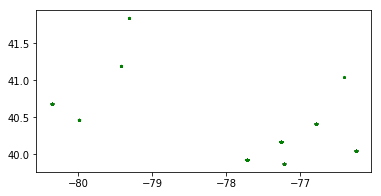

In [13]:
# PA2016["cde_agencies"].head()
# PA2016["nibrs_incident"].head()

tempDF = PA2016["cde_agencies"].merge(right=PA2016["nibrs_incident"], how="inner", on="agency_id")
agencyLatLonDF = tempDF[["incident_id", "icpsr_lat", "icpsr_lng"]]. \
    rename(columns={"icpsr_lat": "lat", "icpsr_lng": "lng"})
agencyLatLonDF['geometry'] = agencyLatLonDF.apply(lambda z: Point(z.lng, z.lat), axis=1)
agencyLatLonDF = gpd.GeoDataFrame(agencyLatLonDF)

agencyLatLonDF.crs = {'init' :'epsg:4326'}
agencyLatLonDF.plot(marker='*', color='green', markersize=5)

Next, we load the census data collected from the U.S. Census Bureau using GeoPandas and lay the dots we acquired in previous cell onto the map.

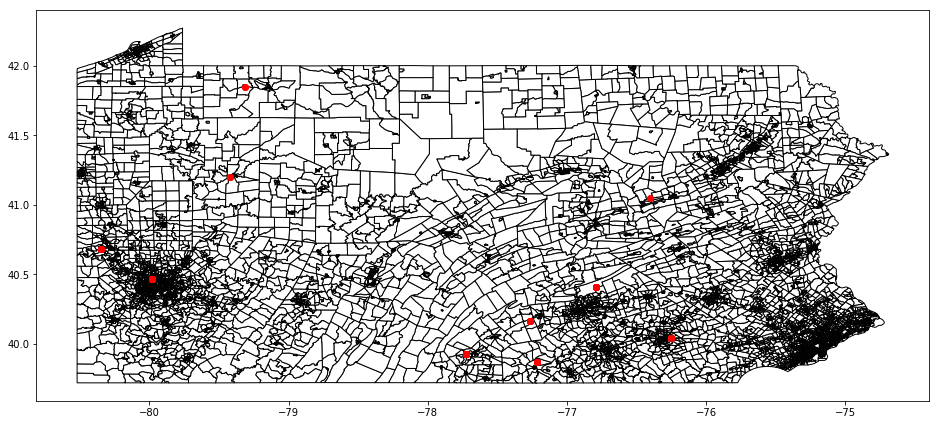

In [14]:
dfPA = gpd.read_file('PA-Geo/cb_2017_42_bg_500k.shp')
agencyLatLonDF = agencyLatLonDF.to_crs(dfPA.crs)
base = dfPA.plot(color='white', edgecolor='black', figsize=(16, 16))
agencyLatLonDF.plot(ax=base, marker='o', color='red', markersize=30, figsize=(16, 16))

Actually, there are only 28 unique coordinates in the `PA-2016` data with many overlapping points.

Finally, we tried presenting the dots and the frequencies of incidents associated with each dot using heatmap.

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in log


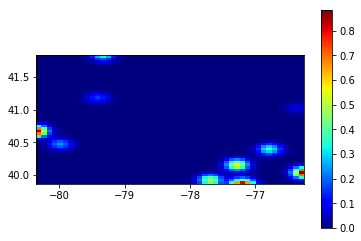

In [15]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()
    
heatmap(agencyLatLonDF.dropna(axis = 0), bins=50, smoothing=1.5)

### Location Types with Different Offense Types

Before examining the relationship between variables, let's look at the top 10 most frequent offense types in `PA-2016` data.

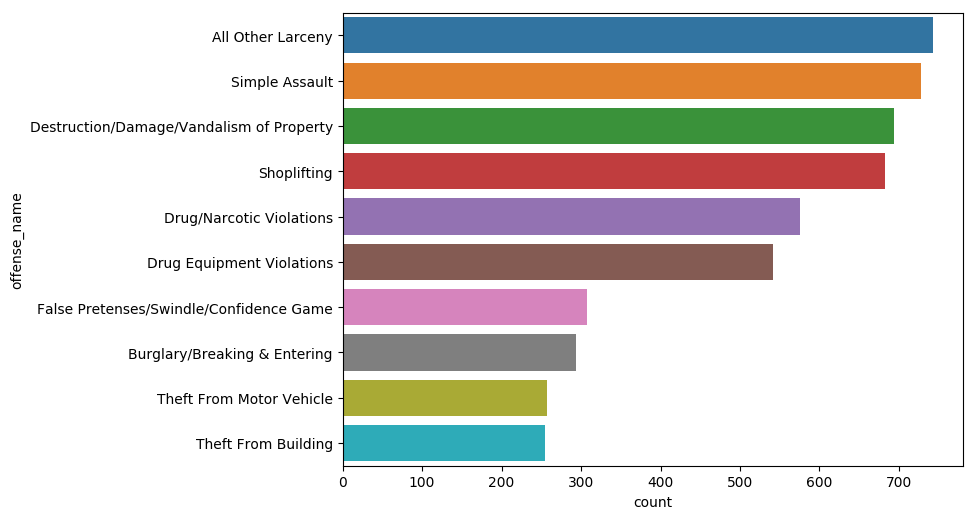

In [16]:
topCrimeTypes = countPlot(PA2016['nibrs_offense'], 'offense_name', topK=10, ret=True)

The most frequent offense types include, roughly speaking, larceny (theft such as shoplifting), simple assult, property damage, and drug violation.

Next, let's also look at the top 10 locations where these offenses occur.

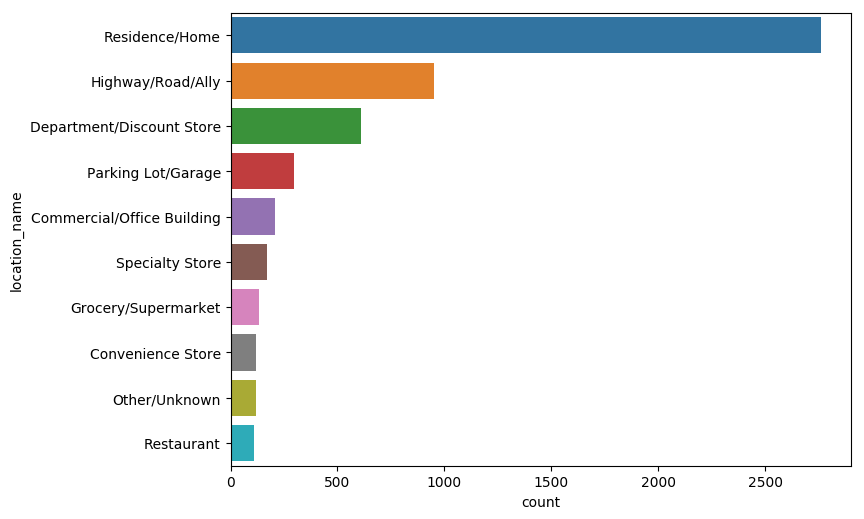

In [17]:
countPlot(PA2016['nibrs_offense'], 'location_name', topK=10)

Knowing the top offense types, it is not too surprising that the top locations are residence, road, and shops.

We can verify this relationship in another count plot conditioned on the top 5 location types. Then, compare the distributions of different colors (hues).

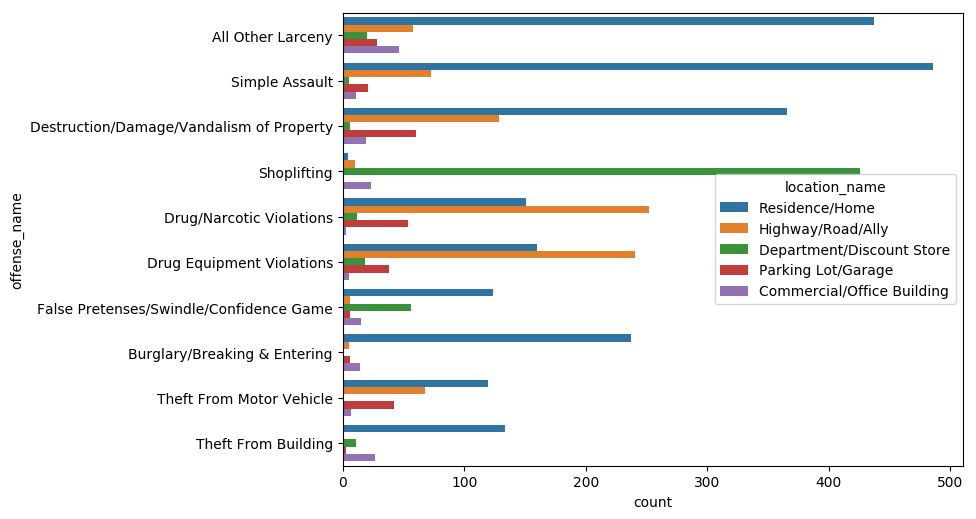

In [30]:
countPlot(PA2016['nibrs_offense'], 'offense_name', hue='location_name', topK=10, topKHues=5)

The most concentrated distribution is department/discount stores, where most offenses are shoplifting.

In addition, drug violations are of top frequency on the road and garage, but of moderate frequency at residence.

Instead, the most frequent offense types at residence locations are thefts, simple assault, and property damage.

### Monthly Offense Distributions with Different Offense Types

As another factor, let's examine how offenses are distributed over months by a count plot.

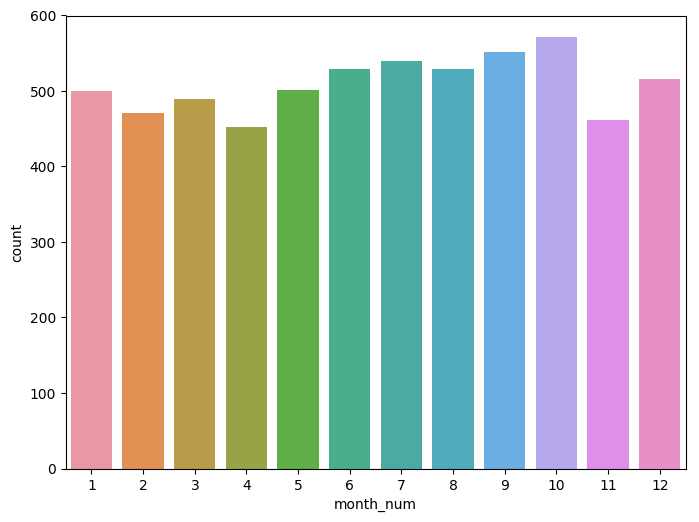

In [19]:
# Offense distribution by month
countPlot(PA2016['incident_offense'], 'month_num', vertical=True, sort=False)

The above distribution shows some slight peak months in the summer and fall (June through October).

We might wonder whether the monthly offense distributions agree conditioned on each offense type, so we can make a similar count plot grouped by the top 5 offense types.

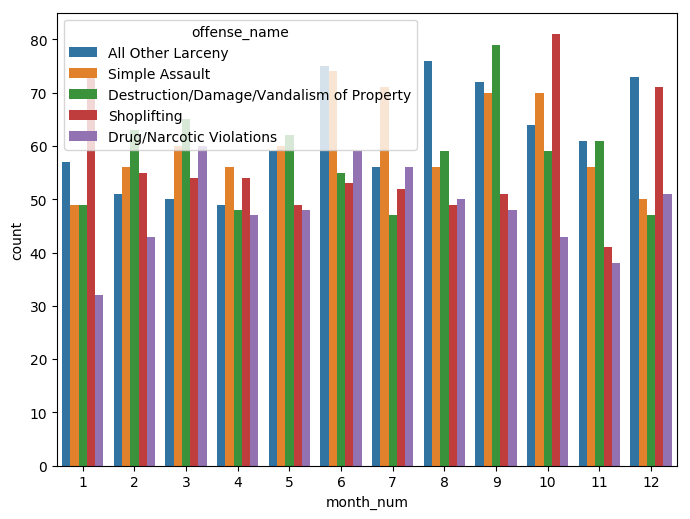

In [20]:
# Offense distribution by (offense type, month)
countPlot(PA2016['incident_offense'], 'month_num', hue='offense_name', \
          vertical=True, sort=False, sortHues=True, topKHues=5)

Interestingly, different offense types have quite different peak and off months. For example, Janurary is considered a off month for drug violation, but a peak month for shoplifting.

### Offender-victim Relationship with Different Offense Types

The `relationship` data in the NIBRS seems really interesting to us. Here we are particularly interested in the relationship between the victim/offender and how does it correlate with the crime type that had been committed on the victim.

#### Joining the tables

In order to analyze the relationship between the `relationship between victim/offender` and `offense type`, we first need to join three dataframes we need, which would be `nibrs_victim_offense`, `nibrs_offense`, and `nibrs_victim_offender_rel`. The NIBRS dataset includes non-human objects such as places or properties as victim. Since there's no relationship between a place or object and a human (or actually there is?), we should get a smaller joined dataframe after the joining process.

In [21]:
victim = PA2016["nibrs_victim_offense"]
print(len(victim))
print(len(victim["offense_id"].unique()))
victim.head()

6684
6107


,victim_id,offense_id
0,91038017,91124963
1,91038028,91124972
2,91526928,91618994
3,91526926,91618994
4,92412201,92509421


Here we plot the top 10 frequent offense type in our data set. Note that the frquency here might not be consistent with the joining results.

In [22]:
offense = PA2016["nibrs_offense"][["offense_id", "incident_id", "offense_name", "location_name"]]
print(len(offense))
offense.head()

6107


,offense_id,incident_id,offense_name,location_name
0,91124963,83457465,Theft From Building,Residence/Home
1,91124972,83457473,Drug Equipment Violations,Highway/Road/Ally
2,91618994,83886692,Simple Assault,Parking Lot/Garage
3,92509421,84661377,Drug Equipment Violations,Residence/Home
4,92508047,84661375,Simple Assault,Residence/Home


In [24]:
rel = PA2016["nibrs_victim_offender_rel"]
print(len(rel))
rel.head()

1277


,victim_id,offender_id,relationship_name,nibrs_victim_offender_id
0,91526928,94571285,Victim Was Acquaintance,27648864
1,91526928,94571283,Victim Was Acquaintance,27648863
2,91526926,94571285,Victim Was Acquaintance,27648862
3,91526926,94571283,Victim Was Acquaintance,27648076
4,92410630,95465950,Victim Was Boyfriend/Girlfriend,27913447


The joined dataframe has 1344 rows in it and not all top 10 offense types show up in it. This is because either the `nibrs_victim_offender_rel` table is not complete, or the victims of a particular offense type is not human (thus has no relationship between offender and victim based on the reasoning in the previous cell).

In [25]:
joinedVictimOffense = victim.merge(right = offense, on = "offense_id", how = "inner")\
                            .merge(right = rel, on = "victim_id", how = "inner")
print(len(joinedVictimOffense))
joinedVictimOffense.head()
# print(topCrimeTypes)
joinedVictimOffense = joinedVictimOffense[joinedVictimOffense["offense_name"].isin(topCrimeTypes)]
print(len(joinedVictimOffense))
print(joinedVictimOffense["offense_name"].unique())

1344
977
['Simple Assault' 'All Other Larceny' 'Burglary/Breaking & Entering'
 'Destruction/Damage/Vandalism of Property' 'Theft From Motor Vehicle' 'Theft From Building']


First thing we could do with our processed data is to do the counting plot of it. In our plot we found that there's a huge inbalance in our dataset that `Simple Assault` offenses are way more common than other offense type. To address this issue, we could normalize the data w.r.t the offense type itself.

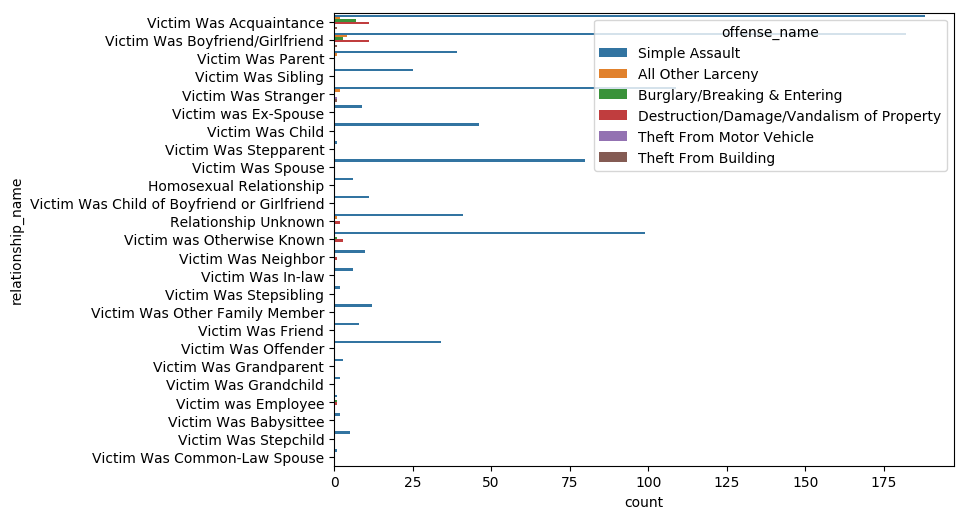

In [26]:
# joinedVictimOffense
plt.figure(figsize=(8,6), dpi=100)
ax = sns.countplot(y = "relationship_name", hue = "offense_name", data = joinedVictimOffense)


In order to normalize the data, filtering out each offense type for computing the normalized values in each series.

In [27]:
filteredDFS = []
# Filter df on the offense name
for offenseName in joinedVictimOffense["offense_name"].unique():
    filteredDFS.append((offenseName, joinedVictimOffense.loc[joinedVictimOffense["offense_name"] == offenseName]))

# Check the number of rows in each df
for element in filteredDFS:
    print(len(element[1]))

922
10
12
29
1
3


Finally, we would like to normalize the relationship counts in each offense type to show the distribution. After normalizing the data, we could concatenate the normalized series into one dataframe and could draw the distribution of each offense name and its distribution as a side-by-side barplot using seaborn's `factorplot`. 

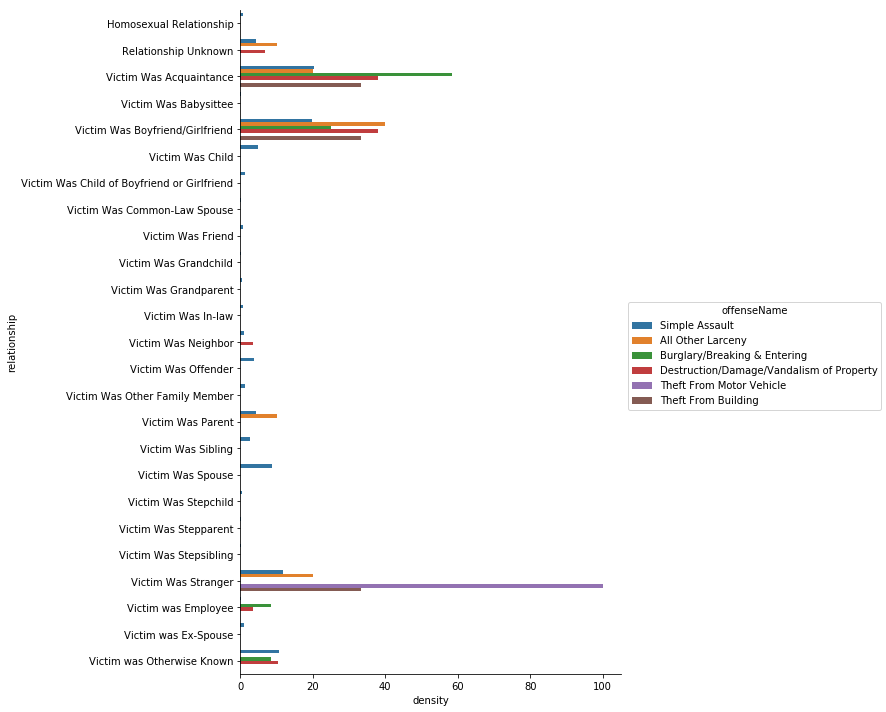

In [28]:
# https://stackoverflow.com/questions/18083187/combining-two-series-in-pandas-along-their-index
# Use "concat" to concat two series with different indices or dimensions
normalizedDFS = [(df[0], pd.Series(df[1]["relationship_name"]).value_counts(normalize=True, sort=False)*100) for df in filteredDFS]
concatDF = pd.concat([elem[1] for elem in normalizedDFS], axis = 1).fillna(value = 0.0).reset_index()
concatDF.columns = ["relationship"] + [elem[0] for elem in normalizedDFS]

# https://stackoverflow.com/questions/38807895/seaborn-multiple-barplots
# Plot multiple cols data with pd.melt and factorplot
reshapeDF = pd.melt(concatDF, id_vars="relationship", var_name="offenseName", value_name="density")
sns.factorplot(x="density", y="relationship", hue="offenseName", data = reshapeDF, kind= "bar", size = 10)

### Temp: Victim Analysis

Plot the distribution of all victim types.

0.623946% (37 / 5930) of victims are Law Enforcement Officers


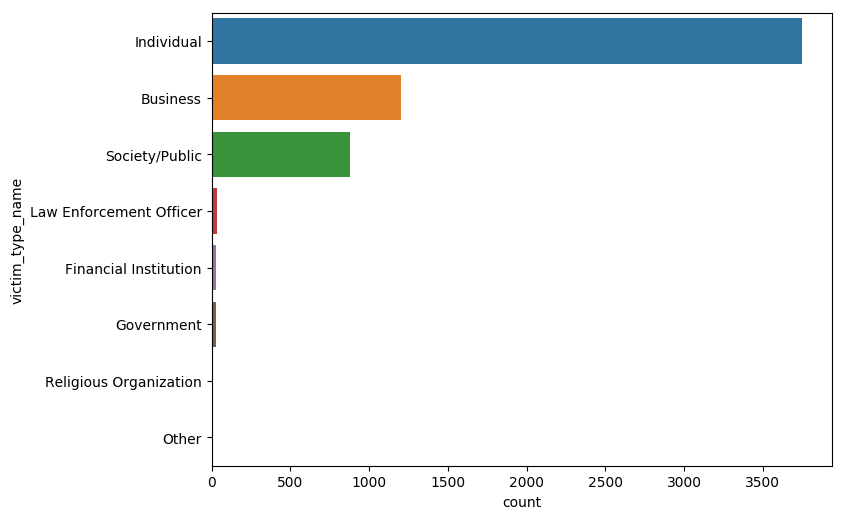

In [29]:
# victimDF = SC2016['nibrs_victim']
victimDF = PA2016['nibrs_victim']
officerVictimCount = (victimDF['victim_type_name'] == 'Law Enforcement Officer').sum()
allVictimCount = len(victimDF)
print('%f%% (%d / %d) of victims are Law Enforcement Officers' % 
     (officerVictimCount / allVictimCount * 100, officerVictimCount, allVictimCount))
countPlot(victimDF, 'victim_type_name')